<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_2_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eyaler/workshop/blob/master/nn_2_mnist.ipynb)

# 2. How to train and test your network (MNIST)

In [ ]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install livelossplot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 7.0MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4ecd24ee-07a4-ece4-85c7-199ff73f1105)


In [ ]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [ ]:
# load dataset
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
print(raw_x_train.shape, raw_y_train.shape)
if len(raw_x_train.shape)==4:
    raw_x_train = np.mean(raw_x_train, axis=-1)
    raw_x_test = np.mean(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
print(raw_x_train.dtype, raw_y_train.dtype)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,)
uint8 uint8


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

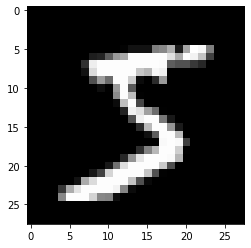

In [ ]:
print(raw_x_train[0])
print(raw_y_train[0])
plt.imshow(raw_x_train[0], cmap='gray')

In [ ]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0 255 0.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [ ]:
n_classes = len(np.unique(raw_y_test))
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train.reshape((train_size, -1))/255
x_test = raw_x_test.reshape((test_size, -1))/255
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(raw_y_test, n_classes)

In [ ]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

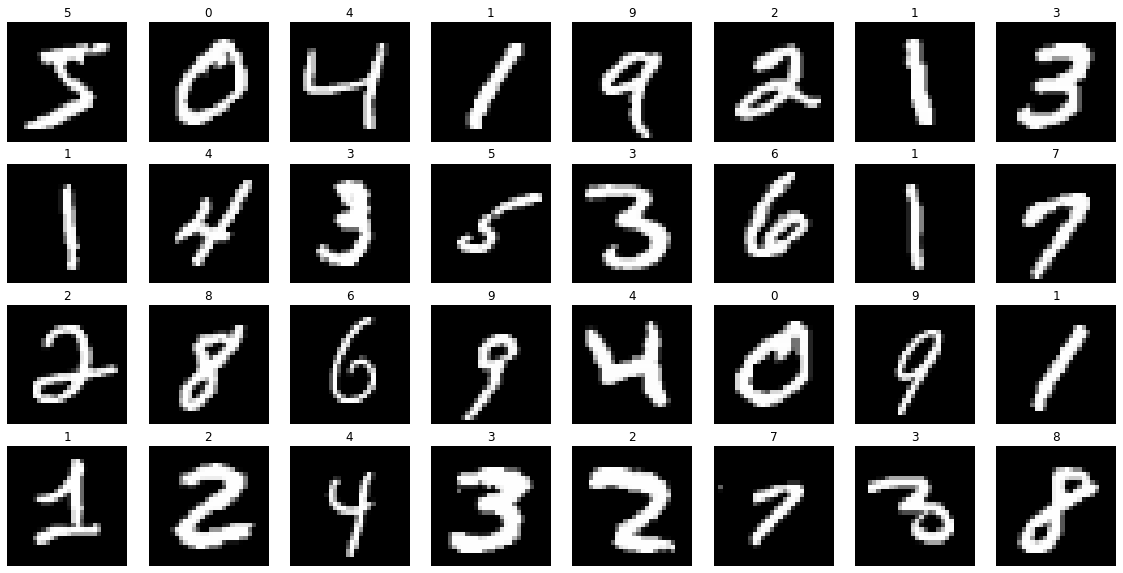

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=raw_y_train[:32],show_labels=True,figsize=(20,10))

In [ ]:
dropout_prob = 0.5

def get_model():
    inputs = Input(shape=(xdim*ydim,))
    f = Dense(512, activation='relu')(inputs)
    f = Dropout(dropout_prob)(f)
    f = Dense(512, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    outputs = Dense(n_classes, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

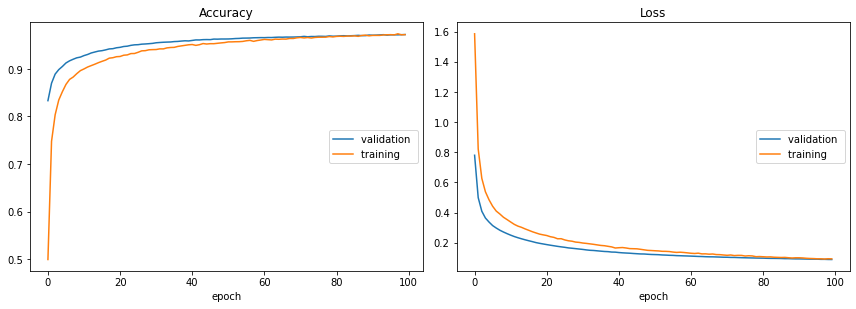

Accuracy
	validation       	 (min:    0.833, max:    0.972, cur:    0.972)
	training         	 (min:    0.500, max:    0.974, cur:    0.972)
Loss
	validation       	 (min:    0.088, max:    0.780, cur:    0.088)
	training         	 (min:    0.091, max:    1.586, cur:    0.093)


In [ ]:
model = get_model()
print(model.summary())
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[PlotLossesKeras()])

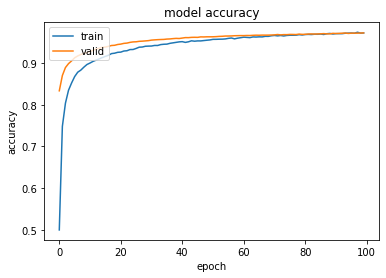

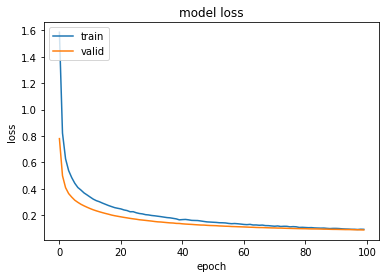

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
loss, acc = model.evaluate(x=x_test, y=y_test)
print(loss, acc)
targets = np.argmax(y_test, axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)

10000/10000 [==============================] - 1s 54us/step
0.07775721648903564 0.9751
[[ 971    0    0    1    0    2    2    1    2    1]
 [   0 1125    3    2    0    0    1    1    3    0]
 [   5    1 1003    4    3    0    1    8    7    0]
 [   0    0    5  989    0    4    0    6    4    2]
 [   0    0    3    0  959    0    5    2    2   11]
 [   3    1    0    9    1  863    7    1    6    1]
 [   4    3    0    0    7    6  937    0    1    0]
 [   2    8   13    3    1    0    0  993    0    8]
 [   3    1    2    8    4    4    5    4  940    3]
 [   5    4    1    7   12    1    0    7    1  971]]


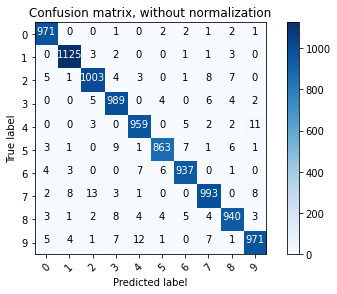

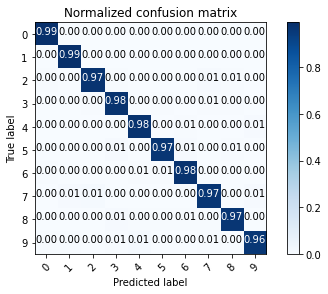

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = np.arange(n_classes)
plot_confusion_matrix(cm, classes=classes)
plot_confusion_matrix(cm, classes=classes, normalize=True)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true=targets, y_pred=predictions, labels=classes)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
# top errors
from sklearn.metrics import log_loss
max_probs = np.max(probabilities, axis=-1)
losses = [log_loss(y_true=y, y_pred=prob, eps=1e-7) for y,prob in zip(y_test,probabilities)]
print('loss\tindex\ttrue\tpredicted\tprobability')
top_errors = sorted(list(zip(losses, np.arange(test_size), targets, predictions, max_probs)), reverse=True)[:32]
titles = []
inds = []
for i,error in enumerate(top_errors):
    titles.append('%d -> %d'%(error[2],error[3]))
    inds.append(error[1])
    if i<10:
        print('%.04f\t%d\t%d\t%d\t\t%.04f'%error)
        #plt.figure()
        #plt.imshow(raw_x_test[error[1]], cmap='gray')

loss	index	true	predicted	probability
1.4027	3520	6	4		0.9982
1.3529	1530	8	7		0.9929
1.2872	2098	2	0		0.9984
1.2532	2654	6	1		0.9960
1.1359	6597	0	7		0.9722
1.1064	2648	9	0		0.9920
1.1018	9587	9	4		0.9959
1.0914	9009	7	2		0.9861
1.0437	5642	1	8		0.6936
1.0092	9770	5	0		0.9842


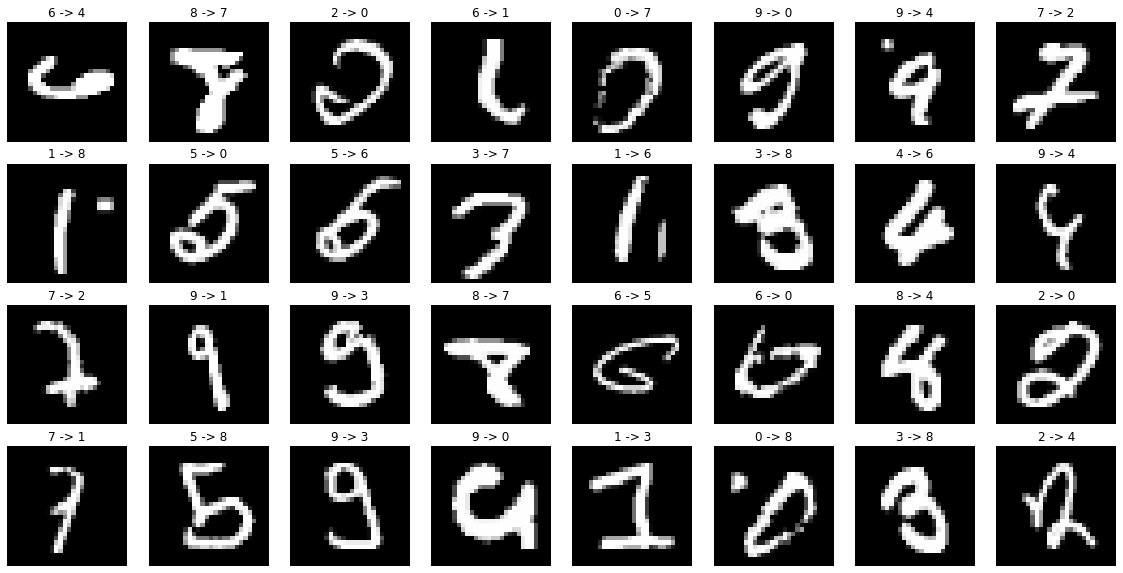

In [ ]:
show_grid(raw_x_test[inds[:32]],4,8,label_list=titles[:32],show_labels=True,figsize=(20,10))